In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


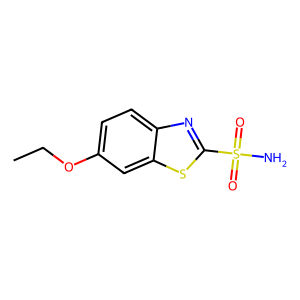

In [46]:

from rdkit import Chem
from rdkit.Chem import Draw

mol = Chem.MolFromSmiles("CCOc1ccc2nc(S(N)(=O)=O)sc2c1")
Draw.MolToImage(mol, size=(300, 300))


In [ ]:
import pandas as pd
file_path = '/content/drive/My Drive/tox21.csv'
df = pd.read_csv(file_path)
df.head()

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O


In [ ]:
! pip install rdkit-pypi pandas scikit-learn joblib


In [ ]:
!pip install "numpy<2.0"


In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from joblib import dump
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
)
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# Use NR-AR endpoint and remove NaNs
df = df[['smiles', 'NR-AR']].dropna()
df['NR-AR'] = df['NR-AR'].astype(int)

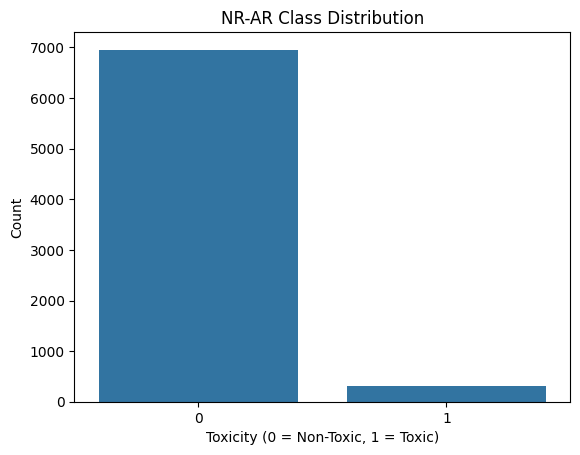

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='NR-AR', data=df)
plt.title("NR-AR Class Distribution")
plt.xlabel("Toxicity (0 = Non-Toxic, 1 = Toxic)")
plt.ylabel("Count")
plt.show()

In [ ]:
# === Step 2: Featurize SMILES ===
def featurize_smiles(smiles_list):
    features = []
    valid_indices = []
    for idx, smi in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smi)
        if mol:
            feats = [
                Descriptors.MolWt(mol),
                Descriptors.MolLogP(mol),
                Descriptors.TPSA(mol),
                Descriptors.NumRotatableBonds(mol),
                Descriptors.NumHAcceptors(mol),
                Descriptors.NumHDonors(mol)
            ]
            features.append(feats)
            valid_indices.append(idx)
    return pd.DataFrame(features, columns=[
        'MolWt', 'MolLogP', 'TPSA', 'RotBonds', 'HAcceptors', 'HDonors'
    ]), valid_indices


In [ ]:
X, valid_idx = featurize_smiles(df['smiles'])
y = df.iloc[valid_idx]['NR-AR'].values

[06:20:06] WARNING: not removing hydrogen atom without neighbors


In [ ]:
X

,MolWt,MolLogP,TPSA,RotBonds,HAcceptors,HDonors
0,258.324,1.34240,82.28,3,5,1
1,204.229,1.29940,49.41,2,2,1
2,276.424,3.75244,32.34,7,2,1
3,206.027,-0.99220,135.29,2,3,5
4,290.444,4.81720,36.92,7,4,0
...,...,...,...,...,...,...
7260,341.451,3.24140,58.56,11,4,2
7261,314.469,4.72350,34.14,1,2,0
7262,288.431,3.87920,37.30,0,2,1
7263,272.388,3.60920,40.46,0,2,2


In [ ]:
y

array([0, 0, 0, ..., 1, 1, 0])

In [ ]:
# === Step 3: Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
# === Step 4: Train Model ===
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [ ]:
# === Step 5: Evaluate Model ===
y_pred = clf.predict(X_test)
print("Classification Report for NR-AR Toxicity:")
print(classification_report(y_test, y_pred))


Classification Report for NR-AR Toxicity:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1389
           1       0.80      0.19      0.30        64

    accuracy                           0.96      1453
   macro avg       0.88      0.59      0.64      1453
weighted avg       0.96      0.96      0.95      1453



In [ ]:
# === Step 6: Save Model ===
dump(clf, 'random_forest_tox21_NR-AR.pkl')

['random_forest_tox21_NR-AR.pkl']

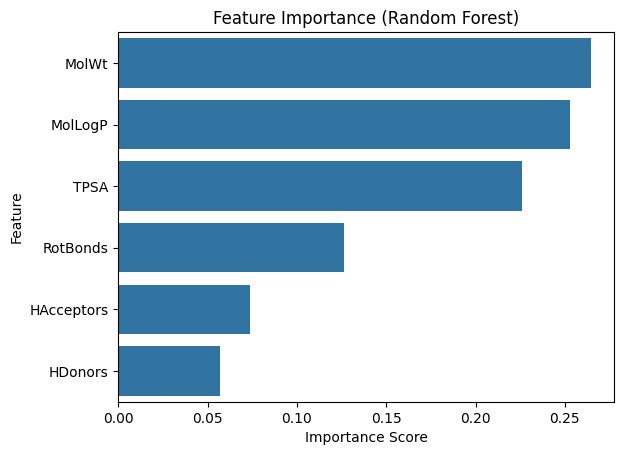

In [ ]:
# === Step 8: Feature importance plot ===
importances = clf.feature_importances_
feature_names = X.columns

sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

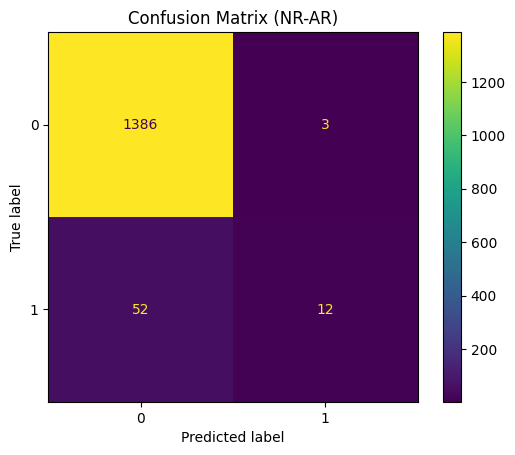

In [ ]:
# === Step 9: Confusion Matrix ===
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.title("Confusion Matrix (NR-AR)")
plt.show()

In [ ]:
from joblib import load
# === Load Trained Model ===
model = load("random_forest_tox21_NR-AR.pkl")

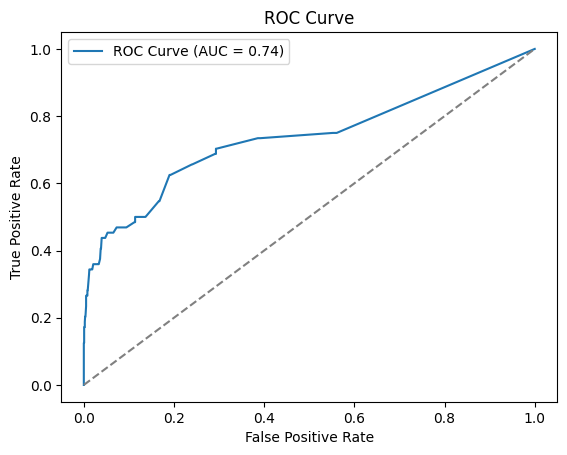

In [ ]:
# === Step 10: ROC Curve ===
y_prob = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [ ]:
# === Input: List of SMILES ===
new_smiles = ['CCO', 'CC(=O)Cl', 'CCCCN(CC)C(=O)Nc1ccc(C)cc1']  # Add more if needed

In [ ]:
# === Generate features
features, valid_smiles = featurize_smiles(new_smiles)


In [ ]:
# === Make predictions
if not features.empty:
    predictions = model.predict(features)

    for smi, pred in zip(valid_smiles, predictions):
        label = 'Toxic' if pred == 1 else 'Non-Toxic'
        print(f"{smi} => {label}")
else:
    print("No valid SMILES to predict.")

0 => Non-Toxic
1 => Non-Toxic
2 => Non-Toxic


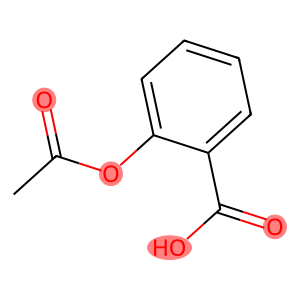

In [39]:
atoms_to_highlight = [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetSymbol() == "O"]
Draw.MolToImage(mol, highlightAtoms=atoms_to_highlight)

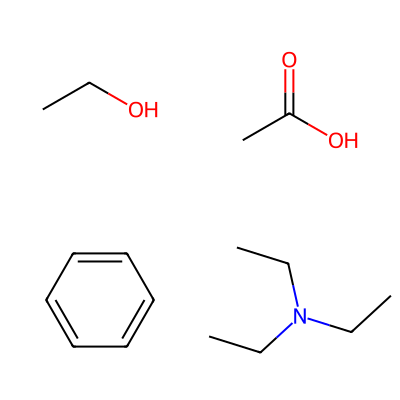

In [40]:
smiles_list = ["CCO", "CC(=O)O", "c1ccccc1", "CCN(CC)CC"]
mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]
Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(200, 200))